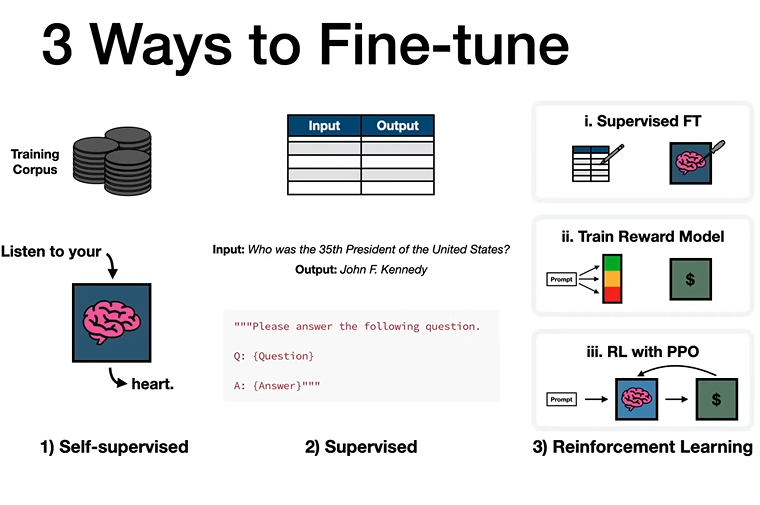

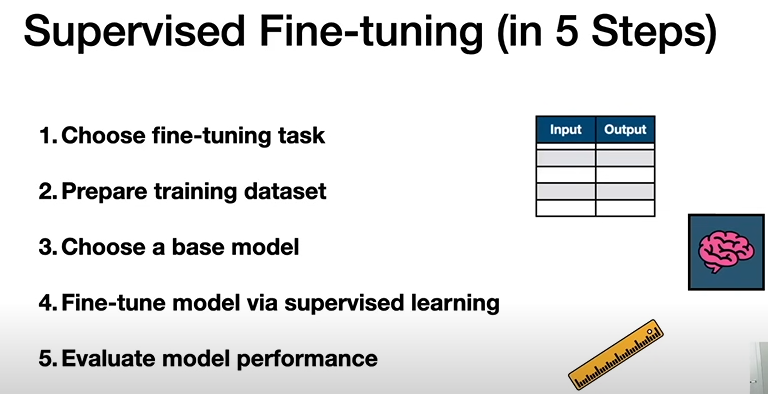

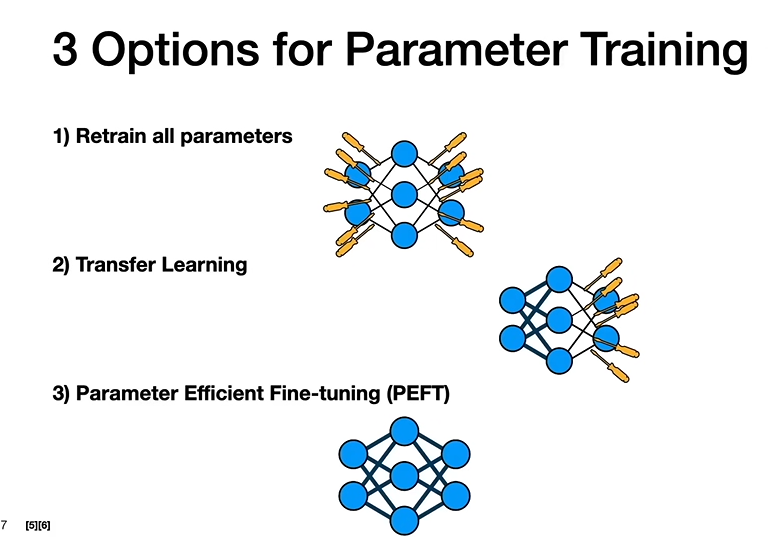

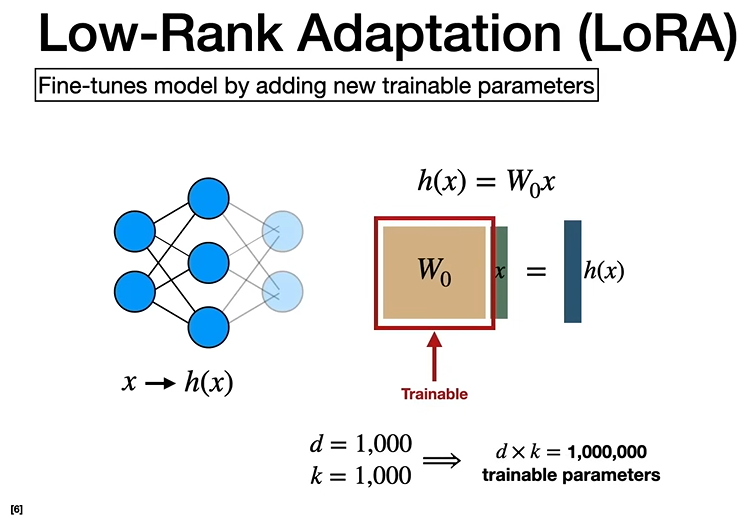

# Example 1

## Custom_Sentiment_Analysis
### DistilBERT, short for "Distilled BERT," is a smaller and faster version of the BERT (Bidirectional Encoder Representations from Transformers) model.
### DistilBERT, a compressed version of BERT, employs a 6-layer Transformer architecture with 768 hidden units, reducing computational complexity while maintaining competitive performance. Utilizing knowledge distillation, it emulates the behavior of BERT, achieving faster inference times and reduced resource requirements. Pre-trained DistilBERT models are available for various languages and tasks, enabling fine-tuning on specific datasets for tasks like text classification and sentiment analysis. Despite its smaller size, DistilBERT offers an efficient solution for natural language processing applications, delivering a balance between model size, speed, and performance in resource-constrained environments.

In [16]:
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv('SMSSpamCollection.txt', sep='\t', names=["label", "message"])
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

X = list(df['message'])
y = list(df['label'])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# Define and load the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenize the training and testing data
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

# Create TensorFlow datasets from tokenized data
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

# Define training arguments
training_args = TFTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=8,   # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    eval_steps=100                   # evaluation steps, set it to an appropriate value
)

# Instantiate the model within the training scope
with training_args.strategy.scope():
    model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

# Initialize the trainer
trainer = TFTrainer(
    model=model,                    # the instantiated 🤗 Transformers model to be trained
    args=training_args,             # training arguments
    train_dataset=train_dataset,    # training dataset
    eval_dataset=test_dataset       # evaluation dataset
)

# Train the model
trainer.train()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions on the test dataset
predictions = trainer.predict(test_dataset)

# Extract predicted labels
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Display confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate classification report
class_report = classification_report(y_test, predicted_labels)

# Display classification report
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[954   1]
 [  4 156]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       955
           1       0.99      0.97      0.98       160

    accuracy                           1.00      1115
   macro avg       0.99      0.99      0.99      1115
weighted avg       1.00      1.00      1.00      1115



In [18]:
# Save the trained model
model.save_pretrained("saved_model")

# Load the saved model
loaded_model = TFDistilBertForSequenceClassification.from_pretrained("saved_model")

Some layers from the model checkpoint at saved_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_291']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at saved_model and are newly initialized: ['dropout_311']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# Define a function for making predictions on new text
def predict_text(text):
    # Tokenize the text
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="tf")
    
    # Make prediction
    logits = loaded_model(inputs)[0]
    
    # Get predicted label
    predicted_label = np.argmax(logits, axis=1).squeeze()
    
    return predicted_label

# Example usage
new_text = "REMINDER FROM O2: To get 2.50 pounds free call credit and details of great offers pls reply 2 this text with your valid name, house no and postcode"
predicted_label = predict_text(new_text)
print("Predicted label:", predicted_label)

Predicted label: 1


In [20]:
#https://github.com/justmarkham/DAT5/blob/master/data/SMSSpamCollection.txt
#https://huggingface.co/docs/transformers/training

# EXAMPLE 2

In [8]:
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [12]:
import pandas as pd
import random

# Define the text samples and corresponding sentiment labels
texts = [
    "I love this product, it's amazing!",
    "The service was terrible, I'm very disappointed.",
    "This movie is just okay, nothing special.",
    "I had a neutral experience with the company.",
    "The food at the restaurant was excellent.",
    "I don't recommend this book, it's boring.",
    "The hotel room was clean and comfortable.",
    "The customer support team was helpful.",
    "The weather today is neither good nor bad.",
    "I'm satisfied with the performance of the device.",
    "The experience was unpleasant, I won't go back.",
    "The new feature is fantastic, I'm impressed.",
    "The traffic was awful, it took forever to get home.",
    "The product quality is subpar, I expected better.",
    "The atmosphere of the place was relaxing.",
    "The delivery was delayed, very frustrating.",
    "The staff was friendly and welcoming.",
    "I'm indifferent towards this product.",
    "The concert was amazing, I had a great time.",
    "The user interface is user-friendly and intuitive.",
    "The price is too high for the value provided.",
    "The event was cancelled, what a disappointment.",
    "The movie plot was predictable, not worth watching.",
    "I'm ambivalent about this issue.",
    "The game performance was flawless.",
    "The experience left me feeling unsatisfied.",
    "I highly recommend this service!",
    "The customer experience needs improvement.",
    "The coffee tasted awful, I couldn't finish it.",
    "The software is buggy, needs fixing.",
    "The meeting was unproductive, a waste of time.",
    "I have mixed feelings about this decision.",
    "The presentation was engaging and informative.",
    "The product exceeded my expectations.",
    "The feedback received was constructive.",
    "The support staff was unhelpful and rude.",
    "The hotel amenities were lacking.",
    "I'm content with the outcome.",
    "The performance of the device was disappointing.",
    "The service quality has deteriorated over time.",
    "The delivery person was rude and unprofessional.",
    "The movie was a masterpiece, I enjoyed every minute of it.",
    "The website navigation is confusing, needs improvement.",
    "The customer service agent was polite and efficient.",
    "The software update fixed many issues, it's much better now.",
    "The traffic was light today, I reached my destination quickly.",
    "The restaurant ambiance was cozy and inviting.",
    "I'm on the fence about recommending this product.",
    "The concert venue had great acoustics, the music sounded amazing."
]

# Assign labels to each sample and convert to numerical values
sentiment_map = {'positive': 2, 'negative': 0, 'neutral': 1}
labels = [sentiment_map[random.choice(['positive', 'negative', 'neutral'])] for _ in range(len(texts))]

# Create a DataFrame from the data
data = {'text': texts, 'sentiment': labels}
df = pd.DataFrame(data)

print(df.shape)
df.head()

(49, 2)


,text,sentiment
0,"I love this product, it's amazing!",1
1,"The service was terrible, I'm very disappointed.",1
2,"This movie is just okay, nothing special.",2
3,I had a neutral experience with the company.,2
4,The food at the restaurant was excellent.,0


In [13]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.20, random_state=0)

In [15]:
# Define and load the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenize the training and testing data
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

# Create TensorFlow datasets from tokenized data
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

# Define training arguments
training_args = TFTrainingArguments(
    output_dir='./results_sentiment',    # output directory
    num_train_epochs=3,                   # total number of training epochs
    per_device_train_batch_size=8,        # batch size per device during training
    per_device_eval_batch_size=16,        # batch size for evaluation
    warmup_steps=500,                     # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                    # strength of weight decay
    logging_dir='./logs_sentiment',       # directory for storing logs
    logging_steps=10,
    eval_steps=100                        # evaluation steps, set it to an appropriate value
)

# Instantiate the model within the training scope
with training_args.strategy.scope():
    model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

# Initialize the trainer
trainer = TFTrainer(
    model=model,                    # the instantiated 🤗 Transformers model to be trained
    args=training_args,             # training arguments
    train_dataset=train_dataset,    # training dataset
    eval_dataset=test_dataset       # evaluation dataset
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate(test_dataset)
print("Evaluation Results:", results)

# Make predictions on the test dataset
predictions = trainer.predict(test_dataset)

# Extract predicted labels
predicted_labels = tf.argmax(predictions.predictions, axis=1).numpy()

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Display confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate classification report
class_report = classification_report(y_test, predicted_labels)

# Display classification report
print("\nClassification Report:")
print(class_report)

# Save the trained model
model.save_pretrained("saved_model_sentiment")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Evaluation Results: {'eval_loss': 1.1175997257232666}
Confusion Matrix:
[[0 0 4]
 [0 0 4]
 [0 0 2]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         4
           2       0.20      1.00      0.33         2

    accuracy                           0.20        10
   macro avg       0.07      0.33      0.11        10
weighted avg       0.04      0.20      0.07        10



C:\Users\Abhishek_Jaiswal\AppData\Local\miniconda3\envs\mlenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abhishek_Jaiswal\AppData\Local\miniconda3\envs\mlenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abhishek_Jaiswal\AppData\Local\miniconda3\envs\mlenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [16]:
# Load the saved model
loaded_model = TFDistilBertForSequenceClassification.from_pretrained("saved_model_sentiment")

# Define a function for making predictions on new text
def predict_text(text):
    # Tokenize the text
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="tf")
    
    # Make prediction
    logits = loaded_model(inputs)[0]
    
    # Get predicted label
    predicted_label = tf.argmax(logits, axis=1).numpy().squeeze()
    
    return predicted_label

# Example usage
new_text = "This restaurant provides excellent service."
predicted_label = predict_text(new_text)
print("Predicted label:", predicted_label)

Some layers from the model checkpoint at saved_model_sentiment were not used when initializing TFDistilBertForSequenceClassification: ['dropout_119']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at saved_model_sentiment and are newly initialized: ['dropout_139']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted label: 2


# EXAMPLE 3

## Steps By Step Tutorial To Fine Tune LLAMA 2

# Step 1: Import All the Required Libraries

In [4]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

### Dataset format
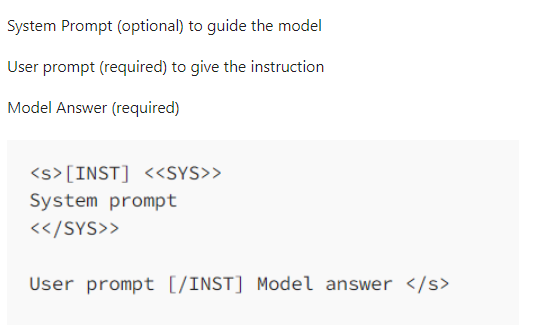

### We will reformat our instruction dataset to follow Llama 2 template.

### Orignal Dataset: https://huggingface.co/datasets/timdettmers/openassistant-guanaco

### Reformat Dataset following the Llama 2 template with 1k sample: https://huggingface.co/datasets/mlabonne/guanaco-llama2-1k

### Complete Reformat Dataset following the Llama 2 template: https://huggingface.co/datasets/mlabonne/guanaco-llama2

### To know how this dataset was created, you can check this notebook. https://colab.research.google.com/drive/1Ad7a9zMmkxuXTOh1Z7-rNSICA4dybpM2?usp=sharing

#### Note: You don’t need to follow a specific prompt template if you’re using the base Llama 2 model instead of the chat version.

### How to fine tune Llama 2

## - Free Google Colab offers a 15GB Graphics Card (Limited Resources --> Barely enough to store Llama 2–7b’s weights)
## - We also need to consider the overhead due to optimizer states, gradients, and forward activations
## - Full fine-tuning is not possible here: we need parameter-efficient fine-tuning (PEFT) techniques like LoRA or QLoRA.
## - To drastically reduce the VRAM usage, we must fine-tune the model in 4-bit precision, which is why we’ll use QLoRA here.

# Step 2: Set the parameters values

### Load a llama-2-7b-chat-hf model (chat model)
### 1. Train it on the mlabonne/guanaco-llama2-1k (1,000 samples), which will produce our fine-tuned model Llama-2-7b-chat-finetune
### 2. QLoRA will use a rank of 64 with a scaling parameter of 16. We’ll load the Llama 2 model directly in 4-bit precision using the NF4 type and train it for one epoch

In [13]:
# The model that you want to train from the Hugging Face hub
model_name = "NousResearch/Llama-2-7b-chat-hf"

# The instruction dataset to use
dataset_name = "mlabonne/guanaco-llama2-1k"

# Fine-tuned model name
new_model = "Llama-2-7b-chat-finetune"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

# Step 3: Load everything and start the fine-tuning process

### First of all, we want to load the dataset we defined. Here, our dataset is already preprocessed but, usually, this is where you would reformat the prompt, filter out bad text, combine multiple datasets, etc.
### Then, we’re configuring bitsandbytes for 4-bit quantization.
### Next, we're loading the Llama 2 model in 4-bit precision on a GPU with the corresponding tokenizer.
### Finally, we're loading configurations for QLoRA, regular training parameters, and passing everything to the SFTTrainer. The training can finally start!

In [ ]:
# Load dataset (you can process it here)
dataset = load_dataset(dataset_name, split="train")

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

# Train model
trainer.train()

In [14]:
# Save trained model
#trainer.model.save_pretrained(new_model)

# Step 4: Check the plots on tensorboard, as follows

In [ ]:
%load_ext tensorboard
%tensorboard --logdir results/runs

# Step 5:Use the text generation pipeline to ask questions like “What is a large language model?” Note that I’m formatting the input to match Llama 2 prompt template.

In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "What is a large language model?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

In [ ]:
# Empty VRAM
del model
del pipe
del trainer
import gc
gc.collect()
gc.collect()

# Step 6: Store New Llama2 Model (Llama-2-7b-chat-finetune)

In [ ]:
# Reload model in FP16 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Step 7: Push Model to Hugging Face Hub

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!huggingface-cli login

model.push_to_hub("entbappy/Llama-2-7b-chat-finetune", check_pr=True)

tokenizer.push_to_hub("entbappy/Llama-2-7b-chat-finetune",check_pr=True)

In [15]:
#https://drive.google.com/file/d/1Bd7c5rioBOmtJbDEax83vAHEPru-r06l/view

# Example 4

In [19]:
import os
import transformers
import torch
from datasets import load_dataset
from trl import SFTTrainer
from peft import LoraConfig
from transformers import AutoTokenizer, AutoModelForCausalLM
#from transformers import BitsAndBytesConfig, GemmaTokenizer

In [18]:
#https://colab.research.google.com/drive/1bmZAiYkkeNKjVLTsNAa864h7hw_rmMnq?usp=sharing#scrollTo=mi50mprVsU_P

In [ ]:
#https://huggingface.co/blog/peft
#https://arxiv.org/abs/2106.09685
#Model code
#https://colab.research.google.com/drive/14xo6sj4dARk8lXZbOifHEn1f_70qNAwy?usp=sharing
#https://github.com/samwit/llm-tutorials
#https://github.com/samwit/langchain-tutorials

# Fine-tuning LLMs with PEFT and LoRA

## PEFT: Parameter-Efficient Fine-Tuning of Billion-Scale Models on Low-Resource Hardware

## Types
## 1. LoRA: LORA: LOW-RANK ADAPTATION OF LARGE LANGUAGE MODELS
## 2. Prefix Tuning: P-Tuning v2: Prompt Tuning Can Be Comparable to Fine-tuning Universally Across Scales and Tasks
## 3. Prompt Tuning: The Power of Scale for Parameter-Efficient Prompt Tuning
## 4. P-Tuning: GPT Understands, Too

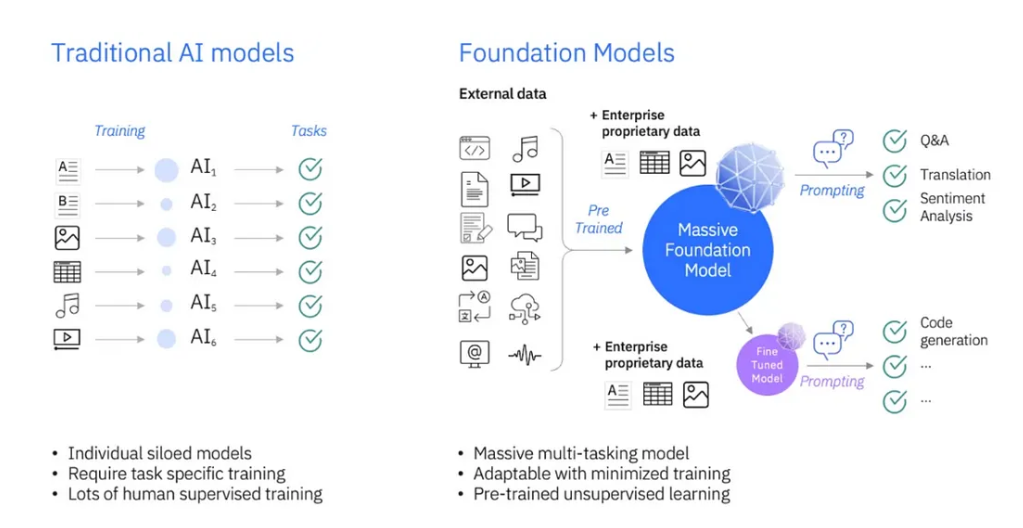

## LLM:
### 1. LLMs (Large Language Models) are a type of Foundational Models.
### 2. They differ from Traditional models in that Foundational models are pre-trained on extensive data.
### 3. After pre-training, we can either use LLMs directly for certain use cases or fine-tune them to adapt to specific scenarios.
### 4. Large Language Models (LLMs) have a wide variety of applications across Customer Service, Marketing, Law, Finance, Healthcare, Education etc. This is where finetuning LLMs come into place.

## ML/DL Model:
### 1. Traditional ML models, on the other hand, require training separate models from scratch for each case.
### 2. This process is both costly and time-consuming compared to using pre-trained LLMs.

## In-Context Learning (ICL):
### 1. One alternative to finetuning is In-Context Learning (ICL).
### 2. ICL is a method of prompt engineering where task demonstrations are included in the prompt given to the model in natural language.
### 3. With ICL, off-the-shelf large language models (LLMs) can be used to solve new tasks without requiring fine-tuning or updating model weights.
### 4. the result depends heavily on the input prompt. This necessitates an empirical art of composing and formatting the prompt to maximize a model’s performance on a desired task. Fine-tuning retrains a model pre-trained on general domains to a specific task

## Efficient Finetuning
### 1. LLM Supervised Finetuning requires labeled data with Instruction, Input/Context, and Response.
### 2. Challenges include increased compute needs as models grow larger, requiring bigger GPUs or multiple GPUs.
### 3. File sizes for checkpoints can become massive, with examples like the T5 XXL checkpoint reaching around 40 GB.
### 4. Best practices for finetuning include using strong regularization, small learning rates, and limiting epochs.hs.
### 5. Focus on fine-tuning only the last layer or a few last layers to avoid high costs and potential overfitt

## PEFT
### 1. LLMs use Parameter Efficient Fine-Tuning (PEFT), similar to traditional fine-tuning methods.
### 2. A popular PEFT method is Low-Rank Adaption (LoRA), pioneered by Microsoft.
### 3. Compared to fine-tuning GPT-3 175B with Adam, LoRA significantly reduces trainable parameters by 10,000 times and GPU memory requirements by 3 times.
### 4. LoRA achieves comparable or superior model quality on RoBERTa, DeBERTa, GPT-2, and GPT-3 despite having fewer trainable parameters.
### 5. It also offers higher training throughput and no additional inference latency.

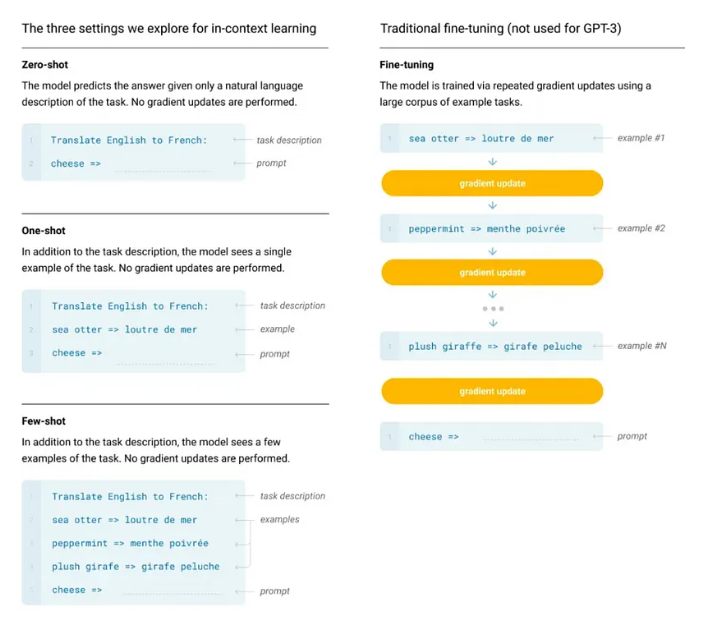

# Finetuning LLMs using LoRA

In [ ]:
# importing libraries
import torch
from transformers import pipeline
from IPython.display import Markdown
# pipeline from transformers (by huggingface) to load dolly 
instruct_pipeline = pipeline(model="databricks/dolly-v2-3b", 
                             device_map="auto",
                             torch_dtype=torch.float16, 
                             trust_remote_code=True,
                             )

prompt = "What are the pricing options of Medium blogging website?"
output1 = instruct_pipeline(prompt)
Markdown(output1[0]['generated_text'])

In [39]:
# mentioning datatypes for better documentation
from typing import Dict, List
from datasets import Dataset, load_dataset, disable_caching
disable_caching() ## disable huggingface cache
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
import torch
from torch.utils.data import Dataset
from IPython.display import Markdown

In [40]:
#Data Loading
# Dataset Preparation
dataset = load_dataset("MBZUAI/LaMini-instruction" , split = 'train') 
small_dataset = dataset.select([i for i in range(200)])
print(small_dataset)
print(small_dataset[0])

# creating templates
prompt_template = """Below is an instruction that describes a task. Write a response that appropriately completes the request. Instruction: {instruction}\n Response:"""
answer_template = """{response}"""

# creating function to add keys in the dictionary for prompt, answer and whole text
def _add_text(rec):
    instruction = rec["instruction"]
    response = rec["response"] 
    # check if both exists, else raise error   
    if not instruction:
        raise ValueError(f"Expected an instruction in: {rec}")
    if not response:
        raise ValueError(f"Expected a response in: {rec}")
    rec["prompt"] = prompt_template.format(instruction=instruction)
    rec["answer"] = answer_template.format(response=response)
    rec["text"] = rec["prompt"] + rec["answer"]
    return rec

# running through all samples
small_dataset = small_dataset.map(_add_text)
print(small_dataset[0])

Generating train split:   0%|          | 0/2585615 [00:00<?, ? examples/s]

Dataset({
    features: ['instruction', 'response', 'instruction_source'],
    num_rows: 200
})
{'instruction': 'List 5 reasons why someone should learn to code', 'response': '1. High demand for coding skills in the job market\n2. Increased problem-solving and analytical skills\n3. Ability to develop new products and technologies\n4. Potentially higher earning potential\n5. Opportunity to work remotely and/or freelance', 'instruction_source': 'alpaca'}


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

{'instruction': 'List 5 reasons why someone should learn to code', 'response': '1. High demand for coding skills in the job market\n2. Increased problem-solving and analytical skills\n3. Ability to develop new products and technologies\n4. Potentially higher earning potential\n5. Opportunity to work remotely and/or freelance', 'instruction_source': 'alpaca', 'prompt': 'Below is an instruction that describes a task. Write a response that appropriately completes the request. Instruction: List 5 reasons why someone should learn to code\n Response:', 'answer': '1. High demand for coding skills in the job market\n2. Increased problem-solving and analytical skills\n3. Ability to develop new products and technologies\n4. Potentially higher earning potential\n5. Opportunity to work remotely and/or freelance', 'text': 'Below is an instruction that describes a task. Write a response that appropriately completes the request. Instruction: List 5 reasons why someone should learn to code\n Response:

In [41]:
#To finetune our LLM, we need to decorate our instruction dataset with a prompt — Instruction: {instruction} Response:{response}

In [ ]:
#Tokenizer and Model Load
# loading the tokenizer for dolly model. The tokenizer converts raw text into tokens
model_id = "databricks/dolly-v2-3b"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

#loading the model using AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    # use_cache=False,
    device_map="auto", #"balanced",
    load_in_8bit=True,
    torch_dtype=torch.float16
)

# resizes input token embeddings matrix of the model if new_num_tokens != config.vocab_size.
model.resize_token_embeddings(len(tokenizer))

In [ ]:
#Data Preparation
from functools import partial
import copy
from transformers import DataCollatorForSeq2Seq

MAX_LENGTH = 256

# Function to generate token embeddings from text part of batch
def _preprocess_batch(batch: Dict[str, List]):  
    model_inputs = tokenizer(batch["text"], max_length=MAX_LENGTH, truncation=True, padding='max_length')    
    model_inputs["labels"] = copy.deepcopy(model_inputs['input_ids'])
    return model_inputs

_preprocessing_function = partial(_preprocess_batch)

# apply the preprocessing function to each batch in the dataset
encoded_small_dataset = small_dataset.map(
        _preprocessing_function,
        batched=True,
        remove_columns=["instruction", "response", "prompt", "answer"],
)
processed_dataset = encoded_small_dataset.filter(lambda rec: len(rec["input_ids"]) <= MAX_LENGTH)

# splitting dataset
split_dataset = processed_dataset.train_test_split(test_size=14, seed=0)
print(split_dataset)

# takes a list of samples from a Dataset and collate them into a batch, as a dictionary of PyTorch tensors.
data_collator = DataCollatorForSeq2Seq(
        model = model, tokenizer=tokenizer, max_length=MAX_LENGTH, pad_to_multiple_of=8, padding='max_length')

In [ ]:
#Coniguring LoRA
from peft import LoraConfig, get_peft_model, prepare_model_for_int8_training

LORA_R = 256 # 512
LORA_ALPHA = 512 # 1024
LORA_DROPOUT = 0.05
# Define LoRA Config
lora_config = LoraConfig(
                 r = LORA_R, # the dimension of the low-rank matrices
                 lora_alpha = LORA_ALPHA, # scaling factor for the weight matrices
                 lora_dropout = LORA_DROPOUT, # dropout probability of the LoRA layers
                 bias="none",
                 task_type="CAUSAL_LM",
                 target_modules=["query_key_value"],
)

# Prepare int-8 model for training - utility function that prepares a PyTorch model for int8 quantization training. <https://huggingface.co/docs/peft/task_guides/int8-asr>
model = prepare_model_for_int8_training(model)
# initialize the model with the LoRA framework
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

In [ ]:
#Model training and saving
from transformers import TrainingArguments, Trainer
import bitsandbytes
# define the training arguments first.
EPOCHS = 3
LEARNING_RATE = 1e-4  
MODEL_SAVE_FOLDER_NAME = "dolly-3b-lora"
training_args = TrainingArguments(
                    output_dir=MODEL_SAVE_FOLDER_NAME,
                    overwrite_output_dir=True,
                    fp16=True, #converts to float precision 16 using bitsandbytes
                    per_device_train_batch_size=1,
                    per_device_eval_batch_size=1,
                    learning_rate=LEARNING_RATE,
                    num_train_epochs=EPOCHS,
                    logging_strategy="epoch",
                    evaluation_strategy="epoch",
                    save_strategy="epoch",
)
# training the model 
trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        args=training_args,
        train_dataset=split_dataset['train'],
        eval_dataset=split_dataset["test"],
        data_collator=data_collator,
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()
# only saves the incremental 🤗 PEFT weights (adapter_model.bin) that were trained, meaning it is super efficient to store, transfer, and load.
trainer.model.save_pretrained(MODEL_SAVE_FOLDER_NAME)
# save the full model and the training arguments
trainer.save_model(MODEL_SAVE_FOLDER_NAME)
trainer.model.config.save_pretrained(MODEL_SAVE_FOLDER_NAME)

In [ ]:
#Prediction with the Finetuned Model
# Function to format the response and filter out the instruction from the response.
def postprocess(response):
    messages = response.split("Response:")
    if not messages:
        raise ValueError("Invalid template for prompt. The template should include the term 'Response:'")
    return "".join(messages[1:])
# Prompt for prediction
inference_prompt = "List 5 reasons why someone should learn to cook"
# Inference pipeline with the fine-tuned model
inf_pipeline =  pipeline('text-generation', model=trainer.model, tokenizer=tokenizer, max_length=256, trust_remote_code=True)
# Format the prompt using the `prompt_template` and generate response 
response = inf_pipeline(prompt_template.format(instruction=inference_prompt))[0]['generated_text']
# postprocess the response
formatted_response = postprocess(response)
formatted_response

In [ ]:
#https://anirbansen2709.medium.com/finetuning-llms-using-lora-77fb02cbbc48

# Performance and Scalability

### Training large transformer models and deploying them to production present various challenges. During training, the model may require more GPU memory than available or exhibit slow training speed. In the deployment phase, the model can struggle to handle the required throughput in a production environment.

### This documentation aims to assist you in overcoming these challenges and finding the optimal setting for your use-case.

### The guides are divided into training and inference sections, as each comes with different challenges and solutions. Within each section you’ll find separate guides for different hardware configurations, such as single GPU vs. multi-GPU for training or CPU vs. GPU for inference.

## Quantization

### Quantization techniques focus on representing data with less information while also trying to not lose too much accuracy. This often means converting a data type to represent the same information with fewer bits. For example, if your model weights are stored as 32-bit floating points and they’re quantized to 16-bit floating points, this halves the model size which makes it easier to store and reduces memory-usage. Lower precision can also speedup inference because it takes less time to perform calculations with fewer bits.


### Transformers supports several quantization schemes to help you run inference with large language models (LLMs) and finetune adapters on quantized models. This guide will show you how to use Activation-aware Weight Quantization (AWQ), AutoGPTQ, and bitsandbytes.

In [3]:
#Quanto
from transformers import AutoModelForCausalLM, AutoTokenizer, QuantoConfig

model_id = "facebook/opt-125m"
tokenizer = AutoTokenizer.from_pretrained(model_id)
quantization_config = QuantoConfig(weights="int8")
#quantized_model = AutoModelForCausalLM.from_pretrained(model_id, device_map="cuda:0", quantization_config=quantization_config)

In [2]:
#bitsandbytes
from transformers import AutoModelForCausalLM

#model_8bit = AutoModelForCausalLM.from_pretrained("bigscience/bloom-1b7", device_map="auto", load_in_8bit=True)

In [4]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(llm_int8_enable_fp32_cpu_offload=True)

In [5]:
#https://huggingface.co/docs/transformers/en/quantization?bnb=8-bit